### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

In [2]:
data_nights = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv', index_col='date')
data_nights = data_nights.drop('Unnamed: 0', axis=1)
data_nights
nights_PAC = data_nights[['nights_PAC']]
nights_PAC.head()

,nights_PAC
date,
2010-01-01,956.88
2010-02-01,1114.93
2010-03-01,1327.84
2010-04-01,1727.31
2010-05-01,2066.52


In [3]:
data_temp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/avgtemp_2010-2017.csv', index_col='date')
data_temp = data_temp.drop('Unnamed: 0', axis=1)
data_temp
avgtemp_PAC = data_temp[['avgtemp_PAC']]
avgtemp_PAC.head()

,avgtemp_PAC
date,
2010-01-01,5.0
2010-02-01,7.0
2010-03-01,9.0
2010-04-01,14.0
2010-05-01,17.0


In [4]:
data_daysoff = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2010-2017.csv', index_col='date')
data_daysoff = data_daysoff.drop('Unnamed: 0', axis=1)
data_daysoff.head()

,daysoff
date,
2010-01-01,11
2010-02-01,9
2010-03-01,9
2010-04-01,10
2010-05-01,12


In [5]:
data_gdp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/regionalGDP_2010-2015.csv', index_col='date')
data_gdp = data_gdp.drop('Unnamed: 0', axis=1)
data_gdp
gdp_PAC = data_gdp[['gdp_PAC']]
gdp_PAC.head()

,gdp_PAC
date,
2010-01-01,143112.575866
2010-02-01,143112.575866
2010-03-01,143112.575866
2010-04-01,143112.575866
2010-05-01,143112.575866


In [34]:
exog_df = pd.concat([avgtemp_PAC, data_daysoff], axis=1, sort=False)
exog_df.index = pd.to_datetime(exog_df.index)

y_df = pd.concat([nights_PAC, gdp_PAC], axis=1, sort=False)
y_df.index = pd.to_datetime(y_df.index)

y_df_train = y_df.dropna(axis=0, how='any')

exog_df_train = exog_df[(exog_df.index>='2010-01-01')&(exog_df.index<'2016-01-01')]

exog_future_df = exog_df[(exog_df.index>='2016-01-01')&(exog_df.index<'2017-01-01')]

### Stationarity check

In [7]:
from statsmodels.tsa.stattools import adfuller

for column in y_df_train.columns:
    result = adfuller(y_df_train[column])
    print(f'Stationarity test for variable {column}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] < 0.05:
        print('STATIONARY')
        print(f'{column}')
        print('-------')
    else:
        print('NON-STATIONARY')
        print(f'{column}')
        print('-------')

Stationarity test for variable nights_PAC
ADF Statistic: -2.225807
p-value: 0.197013
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
NON-STATIONARY
nights_PAC
-------
Stationarity test for variable gdp_PAC
ADF Statistic: -1.015064
p-value: 0.747730
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
NON-STATIONARY
gdp_PAC
-------


Result:
- Nights and GDP are all non-stationary

#### Figure out which series' seasonality is additive or multiplicative

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# ----- Additive Model below -----

add_data = seasonal_decompose(y_df_train, model='additive')  

add_trend = add_data.trend.dropna()
add_seasonal = add_data.seasonal.dropna()
add_residual = add_data.resid.dropna()

# stationarity_test(add_residual)

# ----- Multiplicative Model below -----

mult_data = seasonal_decompose(y_df_train, model='multiplicative')  

mult_trend = mult_data.trend.dropna()
mult_seasonal = mult_data.seasonal.dropna()
mult_residual = mult_data.resid.dropna()

# stationarity_test(mult_residual)

In [9]:
from statsmodels.tsa.stattools import acf

add_acfs = add_residual.apply(acf, axis=0).apply(np.square, axis=0).apply(np.sum)

mult_acfs = mult_residual.apply(acf, axis=0).apply(np.square, axis=0).apply(np.sum)

additive = add_acfs < mult_acfs
add_cols = additive.index[additive].tolist()
mult_cols = additive.index[~additive].tolist()
print('Additive', add_cols)
print('Multiplicative', mult_cols)

Additive []
Multiplicative ['nights_PAC', 'gdp_PAC']


> Nights PAC is a multiplicative series

In [10]:
mult_exog = seasonal_decompose(exog_df_train, model='multiplicative')
mult_exog_resid = mult_exog.resid.dropna()
mult_exog_resid.head()

,avgtemp_PAC,daysoff
date,,
2010-07-01,1.138510,1.085532
2010-08-01,1.036560,0.873729
2010-09-01,1.001714,0.986072
2010-10-01,0.907118,1.150226
2010-11-01,0.900706,0.994409


### Forecasting the 3 parts: Seasonal, Trend, and Residuals

#### Seasonal forecasts for 2016 (nights only)
- Seasonal naive forecast method: Taking the same seasonal data as 2015

In [11]:
mult_seasonal.tail()

,nights_PAC,gdp_PAC
2015-08-01,1.828675,0.998023
2015-09-01,1.279591,0.996701
2015-10-01,0.903177,0.995384
2015-11-01,0.529655,0.994073
2015-12-01,0.510644,0.992765


In [12]:
mult_seasonal_2016 = mult_seasonal[(mult_seasonal.index>='2015-01-01')&(mult_seasonal.index<'2016-01-01')]
mult_seasonal_2016

,nights_PAC,gdp_PAC
2015-01-01,0.504709,1.007251
2015-02-01,0.585774,1.005924
2015-03-01,0.753537,1.004603
2015-04-01,0.952641,1.003286
2015-05-01,1.167660,1.001974
2015-06-01,1.327215,1.000667
2015-07-01,1.656722,0.999350
2015-08-01,1.828675,0.998023
2015-09-01,1.279591,0.996701
2015-10-01,0.903177,0.995384


#### Trend forecasts for 2016 (nights only)
- non-seasonal forecasting methods ex. ARIMA or Holt's

In [13]:
mult_trend.head()

,nights_PAC,gdp_PAC
2010-07-01,1769.145833,143242.681530
2010-08-01,1765.466667,143502.892859
2010-09-01,1764.709167,143763.104187
2010-10-01,1767.228333,144023.315516
2010-11-01,1766.691667,144283.526845


In [14]:
from pyramid.arima import auto_arima
arima_trend = auto_arima(np.array(mult_trend.nights_PAC), start_p=0, start_q=0, max_p=20, max_q=20, m=12,
                    start_P=0, max_P=20, seasonal=False, d=1, D=1, trace=True,
                    error_action='ignore', suppress_warnings=True, stepwise=False, random=True, random_state=42) 

arima_trend.summary()


Fit ARIMA: order=(6, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(8, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=386.432, BIC=390.587, Fit time=0.007 seconds
Fit ARIMA: order=(5, 1, 0); AIC=333.072, BIC=347.615, Fit time=0.175 seconds
Fit ARIMA: order=(0, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(9, 1, 0); AIC=337.305, BIC=360.158, Fit time=0.874 seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=327.398, BIC=335.708, Fit time=0.107 seconds
Fit ARIMA: order=(10, 1, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 0); AIC=338.841, BIC=349.229, Fit time=0.071 seconds
Total fit time: 1.296 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -159.699
Method:                       css-mle   S.D. of innovations              3.480
Date:                Mon, 20 Aug 2018   AIC                            327.398
Time:                        00:54:48   BIC                            335.708
Sample:                             1   HQIC                           330.642
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1898      1.382      0.861      0.393      -1.518       3.898
ar.L1.D.y      0.3554      0.121      2.943      0.005       0.119       0.592
ma.L1.D.y      0.9999      0.067     14.886      0.000       0.868       1.132
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.8134           +0.0000j            2.8134            0.0000
MA.1           -1.0001           +0.0000j            1.0001            0.5000
-----------------------------------------------------------------------------
"""

In [15]:
arima_trend.fit(mult_trend.nights_PAC)


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [16]:
arima_trend_forecast_2016 = arima_trend.predict(n_periods=12)
arima_trend_forecast_2016

array([1846.45350717, 1846.792287  , 1847.67958289, 1848.76184506,
       1849.91340664, 1851.08960023, 1852.2745491 , 1853.46260997,
       1854.65177698, 1855.84133717, 1857.0310371 , 1858.2207867 ])

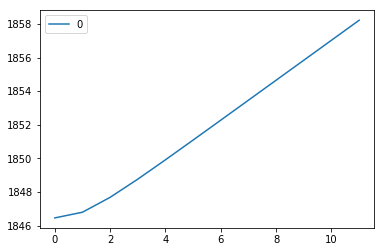

In [17]:
arima_trend_forecast_2016_df = pd.DataFrame(arima_trend_forecast_2016)
arima_trend_forecast_2016_df.plot()

#### Residual forecasts for 2016 (produces forecasts for all but we will use nights forecast only)
- VAR model
- Takes all variables into account and gives predictions for all
- We will be taking the VAR prediction for nights_PAC only

In [18]:
mult_residual.head()

,nights_PAC,gdp_PAC
2010-07-01,1.008754,0.999742
2010-08-01,1.002161,0.999256
2010-09-01,0.999191,0.998770
2010-10-01,0.949383,0.998284
2010-11-01,0.973639,0.997799


In [49]:
from statsmodels.tsa.api import VAR, DynamicVAR

model = VAR(endog=mult_residual, exog=mult_exog_resid, dates=mult_residual.index)

# lagorder_results = model.select_order(30)
# print(lagorder_results.summary())

results = model.fit(maxlags=10, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 20, Aug, 2018
Time:                     01:06:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.7119
Nobs:                     59.0000    HQIC:                  -18.9266
Log likelihood:           404.955    FPE:                5.25948e-09
AIC:                     -19.0640    Det(Omega_mle):     4.46979e-09
--------------------------------------------------------------------
Results for equation nights_PAC
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.931772         1.283162           -0.726           0.468
exog0         0.049652         0.039194            1.267           0.205
exog1         0.111192         0.046762            2.378           0.017

Results for e

/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [50]:
lag_order = results.k_ar
print(lag_order)

mult_resid_forecast_2016 = results.forecast(mult_residual.values[-lag_order:], 12, 
                                           exog_future=exog_future_df)
mult_resid_forecast_2016

1


array([[2.56003435, 1.03707412],
       [2.25838273, 1.06404187],
       [2.50872341, 1.07994405],
       [2.70571948, 1.0975993 ],
       [2.97435813, 1.11577833],
       [2.95096748, 1.13085974],
       [3.46509537, 1.15019483],
       [3.21411284, 1.159507  ],
       [3.05316745, 1.1568498 ],
       [2.88184527, 1.14455324],
       [2.63200507, 1.12727372],
       [2.53163512, 1.11286294]])

In [51]:
mult_resid_forecast_2016_df = pd.DataFrame(mult_resid_forecast_2016)
mult_resid_forecast_2016_df

,0,1
0,2.560034,1.037074
1,2.258383,1.064042
2,2.508723,1.079944
3,2.705719,1.097599
4,2.974358,1.115778
5,2.950967,1.130860
6,3.465095,1.150195
7,3.214113,1.159507
8,3.053167,1.156850
9,2.881845,1.144553


#### Putting the decomposed forecasts back together (multiplicative; nights only)

In [52]:
mult_seasonal_2016_array = mult_seasonal_2016.nights_PAC.values
mult_seasonal_2016_df = pd.DataFrame(mult_seasonal_2016_array)
mult_seasonal_2016_df.head(2)


,0
0,0.504709
1,0.585774


### 2016 Nights forecast

In [53]:
mult_seasonal_2016_df[0]

0     0.504709
1     0.585774
2     0.753537
3     0.952641
4     1.167660
5     1.327215
6     1.656722
7     1.828675
8     1.279591
9     0.903177
10    0.529655
11    0.510644
Name: 0, dtype: float64

In [54]:
forecast_2016 = mult_seasonal_2016_df[0] * arima_trend_forecast_2016_df[0] * mult_resid_forecast_2016_df[0]
forecast_2016

0      2385.749473
1      2443.126248
2      3492.884974
3      4765.328151
4      6424.823100
5      7249.917526
6     10633.350473
7     10893.851312
8      7245.764122
9      4830.414936
10     2588.802917
11     2402.242565
Name: 0, dtype: float64

#### Actual values for 2016

In [55]:
nights_PAC_2016 = nights_PAC[(nights_PAC.index>='2016-01-01')&(nights_PAC.index<'2017-01-01')]
nights_PAC_2016 = np.array(nights_PAC_2016.nights_PAC)
nights_PAC_2016_df = pd.DataFrame(nights_PAC_2016)
nights_PAC_2016_df.head(2)


,0
0,956.28
1,1141.47


### Compare with real number of nights in 2016

#### AIC for 2016 forecast

In [56]:
results.aic

-19.064048460689115

#### MASE for 2016 forecast

#### Function to calculate seasonal MASE
- Doesn't work properly in this specific case as forecast includes only 12 months of data into the future

In [57]:
# Define seasonality as 12 (monthly data) in argument when ground truth data includes at least 24 months

def seasonal_MASE(truth, forecast, seasonality=1):    
    period = truth.shape[0] # T
    # print(period)
    forecast_errors = np.abs(truth - forecast)
    # print(forecast_errors)
    mean_absolute_forecast_error = np.sum(forecast_errors) / period
    # print(mean_absolute_forecast_error)

    naive_period = truth.shape[0] - seasonality # T - m
    # print(naive_period)
    # print(truth[seasonality:])
    # print(truth[:period - seasonality])
    naive_errors = np.abs(truth[seasonality:] - truth[:period - seasonality])
    mean_absolute_naive_error = np.sum(naive_errors) / naive_period
    
    return mean_absolute_forecast_error / mean_absolute_naive_error

#### MASE for 2016 forecast

In [58]:
MASE_2016 = seasonal_MASE(nights_PAC_2016, forecast_2016)
print('MASE: %f' % MASE_2016)

MASE: 9.488829


#### RMSE and MAE for 2016 forecast

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_2016 = np.sqrt(mean_squared_error(nights_PAC_2016, forecast_2016))
mae_2016 = mean_absolute_error(nights_PAC_2016, forecast_2016)
rmse_2016, mae_2016

(4274.685848077745, 3630.2363164460367)

#### Predictions vs. Ground truth for Hotel nights PAC 2016

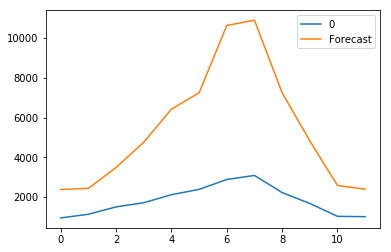

In [60]:
nights_PAC_2016_df.plot(label='Real')
forecast_2016.plot(label='Forecast')
plt.legend()